# Chatbox for COVID-19 help etc. 

In [20]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalMaxPool1D, Flatten, Embedding, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Importing data

In [21]:
with open('data/conversations.json') as f:
    data = json.load(f)

In [22]:
tags=[]
patternss=[]
responses={}
for intent in data['intents']:
    responses[intent['tag']]=intent['responses']
    for patterns in intent['patterns']:
        patternss.append(patterns)
        tags.append(intent['tag'])
    

In [23]:
data = pd.DataFrame({'patterns':patternss, 'tag':tags})

In [24]:
data

,patterns,tag
0,Can my friends visit me?,quarantine_visits
1,Can someone come see me during quarantine?,quarantine_visits
2,Is anyone allowed to visit during quarantine?,quarantine_visits
3,What is a safe distance when someone brings me...,quarantine_visits
4,Are quarantined visits allowed?,quarantine_visits
...,...,...
711,will i die from covid-19,covid_mortality_rate_likelihood
712,Will I die if I get coronavirus?,covid_mortality_rate_likelihood
713,Bye,goodbye
714,See you later,goodbye


In [25]:
# randomly shuffle the data
data = data.sample(frac=1)
data

,patterns,tag
115,Is it possible to detect the disease during th...,testing_information
206,How long should I be in quarantine?,quarantine_what_to_do
533,temperature,symptoms
505,I'm afraid I have covid-19,symptoms
170,what medicine should I be taking for Covid 19,treatment_info
...,...,...
346,Tell me about working from home?,quarantine_social_aid
45,how do i know whether to go to the doctor?,go_hospital_see_doctor
714,See you later,goodbye
386,how can I get tested,testing_locations


# Pre-processing

In [26]:
#remove punctuation and convert to lower case
import string
data['patterns'] = data['patterns'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data['patterns'] = data['patterns'].apply(lambda x: x.lower())
data

,patterns,tag
115,is it possible to detect the disease during th...,testing_information
206,how long should i be in quarantine,quarantine_what_to_do
533,temperature,symptoms
505,im afraid i have covid19,symptoms
170,what medicine should i be taking for covid 19,treatment_info
...,...,...
346,tell me about working from home,quarantine_social_aid
45,how do i know whether to go to the doctor,go_hospital_see_doctor
714,see you later,goodbye
386,how can i get tested,testing_locations


In [27]:
# tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
x_train = tokenizer.texts_to_sequences(data['patterns'])

# add padding to the data
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encode the tags
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data['tag'])
y_train = encoder.fit_transform(data['tag'])


In [28]:
input_shape1 = x_train.shape[1]
input_shape1

23

In [29]:
vocab_size = len(tokenizer.word_index)
vocab_size

636

In [30]:
output_size = encoder.classes_.shape[0]
output_size

44

# Neural Network

In [31]:
i = Input(shape=(input_shape1,))
x = Embedding(vocab_size+1, 10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_size, activation='softmax')(x)
model = Model(i, x)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
# train the model
# train = model.fit(x_train, y_train, epochs=200, batch_size=64)
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
23/23 [==============================] - 1s 4ms/step - loss: 3.7626 - accuracy: 0.0615
Epoch 2/200
23/23 [==============================] - 0s 4ms/step - loss: 3.5854 - accuracy: 0.1145
Epoch 3/200
23/23 [==============================] - 0s 4ms/step - loss: 3.4632 - accuracy: 0.1061
Epoch 4/200
23/23 [==============================] - 0s 4ms/step - loss: 3.4338 - accuracy: 0.1061
Epoch 5/200
23/23 [==============================] - 0s 4ms/step - loss: 3.4235 - accuracy: 0.1061
Epoch 6/200
23/23 [==============================] - 0s 4ms/step - loss: 3.4109 - accuracy: 0.1061
Epoch 7/200
23/23 [==============================] - 0s 4ms/step - loss: 3.3878 - accuracy: 0.1089
Epoch 8/200
23/23 [==============================] - 0s 4ms/step - loss: 3.3602 - accuracy: 0.1508
Epoch 9/200
23/23 [==============================] - 0s 4ms/step - loss: 3.3184 - accuracy: 0.1746
Epoch 10/200
23/23 [==============================] - 0s 4ms/step - loss: 3.2581 - accuracy: 0.1816
Epoch 11/

In [33]:
#save the model
model.save('chatbox_model.h5')

In [ ]:
import pickle
# save the tokenizer, label encoder , response dictionary and input_shape in a single file in the form of a dictionary
pickle.dump({'encoder': encoder, 'tokenizer': tokenizer, 'responses': responses, 'input_shape': input_shape1}, open('chatbox_model.pkl', 'wb'))


# Model Analysis

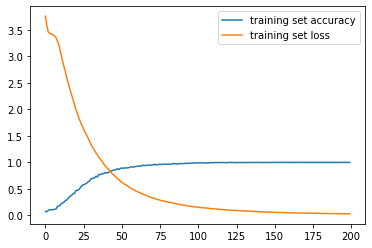

In [15]:
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

# Testing

In [16]:
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape1)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = encoder.inverse_transform([output])[0]
  final_output = random.choice(responses[response_tag])
  print("Covid 19- Chat bot : ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

Covid 19- Chat bot :  What's up
Covid 19- Chat bot :  See you later, thanks for visiting
